In [1]:
import numpy as np

import matplotlib.pyplot as plt

from scipy import signal
from scipy.io import wavfile as wavfile

## https://www.flipcode.com/misc/BeatDetectionAlgorithms.pdf


http://www.flipcode.com/misc/BeatDetectionAlgorithms.pdf

Implement the "Frequency sound selected algorithm #1" (page 9)


In [10]:
class DataStream:
    def __init__(self):
        self.data = [] # fixed dimension, N seconds
        self.start_offset = 0
        # Dire Straits - One World ~107 BPM
        self.filename = '/Users/lkang/psrc/ML/audio/audio/wav/Dire Straits - One World (online-audio-converter.com).wav' #youtube coolio gangsta paradise
        self.sample_size = 1024
        self.step_size = 1024
        
    def read_file(self):
        self.rate, self.data = wavfile.read(self.filename)
        self.data = self.data.astype('float')
        print('data length: ', self.data.shape)
        print('samples: ', self.data.shape[0] / self.sample_size)
        print('dtype: ', self.data.dtype)

    def set_data(self, data):
        self.data = data

    # next sample_size chunk
    def next_sample(self):
        start = 0 # 1000000 # debug/test - start in the middle somewhere
        while True:
            yield self.data[start:start + self.sample_size]
            start += self.step_size
            if start+self.sample_size > len(self.data):
                break


In [3]:
# test DataStream
myd = DataStream()
myd.read_file()
data_gen = myd.next_sample()
s1 = next(data_gen)
print(len(s1))
print(s1.shape)
print(s1[:,0].shape)


data length:  (9704448, 2)
samples:  9477.0
dtype:  float64
1024
(1024, 2)
(1024,)


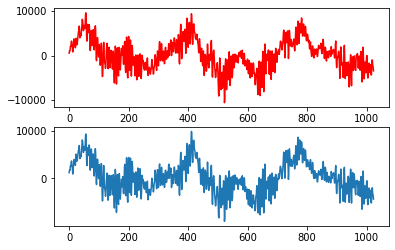

In [4]:
# plot DataStream
plt.subplot(2,1,1)
plt.plot(s1[:, 0], 'r')
plt.subplot(2,1,2)
plt.plot(s1[:, 1])
plt.show()

In [5]:
class History:
    def __init__(self, depth, bands):
        self.depth = depth
        self.bands = bands
        self.ambient_history = np.zeros((depth, bands))
        print('ambient_history.shape', self.ambient_history.shape)
        print('ambient_history.dtype', self.ambient_history.dtype)

    def std(self):
        return np.std(self.ambient_history, axis=0)

    def add_entry(self, new_entry):
#         print('before add_entry: ambient_history.shape:', self.ambient_history.shape)
        self.ambient_history = self.ambient_history[1:].copy()
#         print('after add_entry: ambient_history.shape:', self.ambient_history.shape)
#         print('new_entry.shape: ', new_entry.shape)
        e = new_entry.reshape((1, bands))
#         print('new_entry.shape: ', new_entry.shape)
#         print('e.shape: ', e.shape)

        self.ambient_history = np.append(self.ambient_history, e, axis=0)
#         print('after add_entry: ambient_history.shape:', self.ambient_history.shape)
        
    def power_of_entry(self, new_entry):
        mean = np.mean(self.ambient_history, axis=0)
#         print('mean.shape', mean.shape)
        self.add_entry(new_entry)
        power = np.divide(new_entry, mean, out=np.zeros_like(new_entry), where=mean!=0)
        return power


In [6]:
# test History
bands = 5
myh = History(5, bands)
for i in np.arange(8):
    p = myh.power_of_entry(np.full((bands), fill_value=5, dtype='float'))
    print(p)

ambient_history.shape (5, 5)
ambient_history.dtype float64
[0. 0. 0. 0. 0.]
[5. 5. 5. 5. 5.]
[2.5 2.5 2.5 2.5 2.5]
[1.66666667 1.66666667 1.66666667 1.66666667 1.66666667]
[1.25 1.25 1.25 1.25 1.25]
[1. 1. 1. 1. 1.]
[1. 1. 1. 1. 1.]
[1. 1. 1. 1. 1.]


In [7]:
class FFT_Energy:
    def __init__(self, sample, bands=32, band_size=32):
        self.sample = sample
        self.bands = bands
        self.band_size = band_size
    
    def fft(self):
        data_to_fft = sample[:, 0] # just one channel?
        fft_result = np.fft.fft(data_to_fft)

        self.abs_fft_result = np.absolute(fft_result)
        return self.abs_fft_result

    def calc_energy(self):
        beat_energy = np.ndarray((self.bands))
        for band in range(self.bands):
            band_start = band * self.band_size
            beat_energy[band] = np.mean(self.abs_fft_result[band_start:band_start + self.band_size])
        return beat_energy


In [11]:
# test FFT_Energy
bands = 32
depth = 44
myd = DataStream()
history = History(depth, bands)

myd.read_file()
data_gen = myd.next_sample()

power_array = np.ndarray((0, bands)) # history of power for each sample

sample = next(data_gen)
e = FFT_Energy(sample) # FFT energy
te = e.fft()
print(te)

ambient_history.shape (44, 32)
ambient_history.dtype float64
data length:  (9704448, 2)
samples:  9477.0
dtype:  float64
[0. 0. 0. ... 0. 0. 0.]


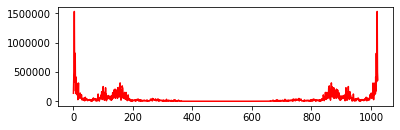

In [9]:
# plot FFT_Energy (abs_fft_result)
plt.subplot(2,1,1)
plt.plot(te, 'r')
plt.show()

In [12]:
# Find the beats!
bands = 32
depth = 44
data_stream = DataStream()
history = History(depth, bands)

data_stream.read_file()
data_gen = data_stream.next_sample()

power_array = np.ndarray((0, bands)) # history of power for each sample

for i in np.arange(4000):
    sample = next(data_gen)
    e = FFT_Energy(sample) # FFT energy
    te = e.fft()
    sample_energy = e.calc_energy()
#     print('sample_energy.shape', sample_energy.shape)
    power = history.power_of_entry(sample_energy)
    p = power.reshape((1, bands))
    power_array = np.append(power_array, p, axis=0)


ambient_history.shape (44, 32)
ambient_history.dtype float64
data length:  (9704448, 2)
samples:  9477.0
dtype:  float64


In [13]:
print('power_array.shape: ', power_array.shape)

power_array.shape:  (4000, 32)


Dire Straits - One World ~107 BPM.

1 window = 1024 samples.  Sample rate is 44.1 KHz
43 windows per second = 60 * 43 windows / minute

(60*43) wpm / 107 bpm = 24.112 windows per beat

Does the plot match this tempo?

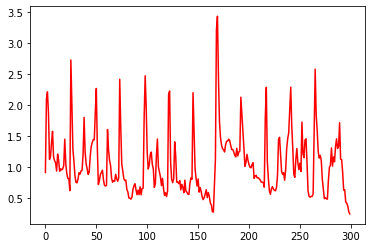

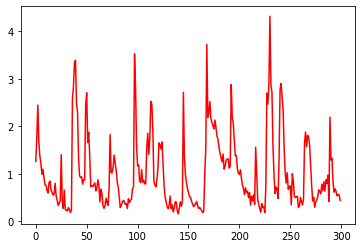

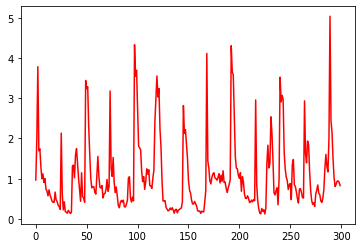

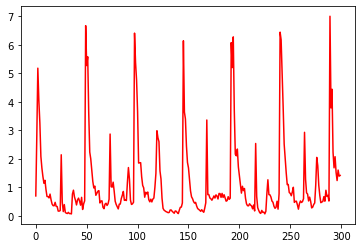

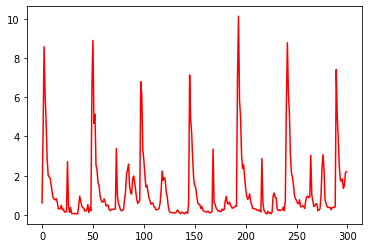

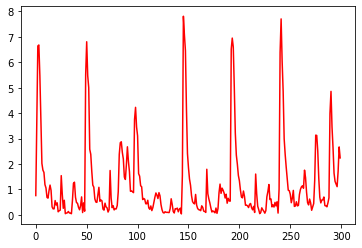

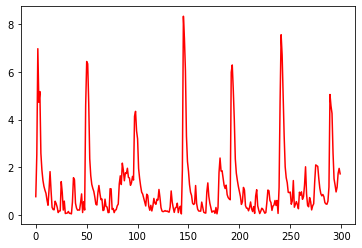

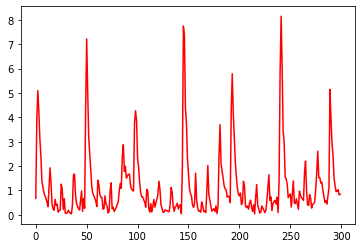

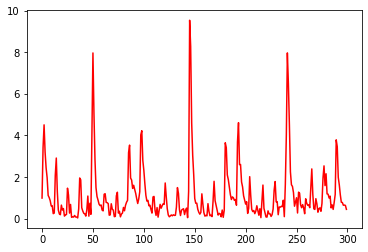

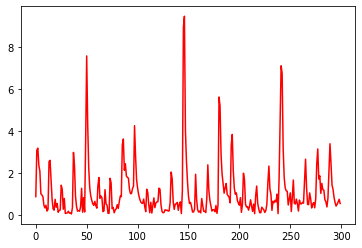

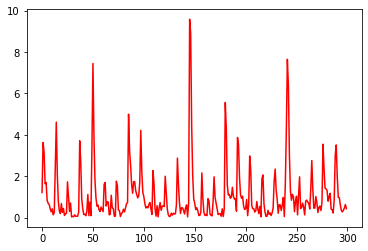

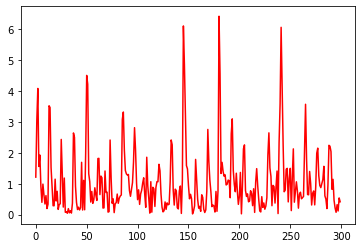

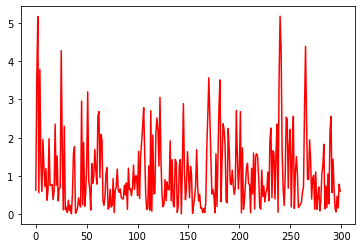

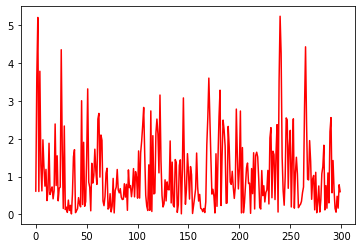

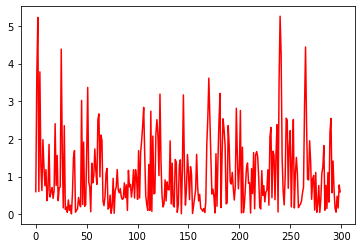

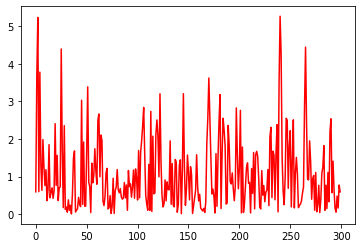

In [14]:
# Plot the 16 frequency bucket bands
for band in np.arange(int(bands/2)):
    plt.subplot(1, 1, 1)
    plt.plot(power_array[1100:1400, band], 'r')
    plt.show()

TODO:
    - combine frequency buckets
    - high frequency cutoff
    - logarithmic frequency groupings
    - autocorrelation
    - BPM calculation